## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

> dropout = 0.1   
> regularizers = L1 0.01    
> batch-normalization = 16  

In [5]:
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization, Activation

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2, l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                    activation="relu",
                                    name="hidden_layer"+str(i+1),
                                    kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                    activation="relu",
                                    name="hidden_layer"+str(i+1),
                                    kernel_regularizer=l1(l1_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
MOMENTUM = 0.95
Dropout_EXP = 0.1
L1_EXP = 1e-2
BATCH_SIZE = 16

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=L1_EXP, drp_ratio=Dropout_EXP)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

def run(batch_size):
    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=batch_size, 
          validation_data=(x_test, y_test), 
          shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    print('Batch size = %s' % batch_size)

    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 26s 528us/step - loss: 15.9086 - accuracy: 0.1828 - val_loss: 8.1332 - val_accuracy: 0.1382
Epoch 2/50
50000/50000 [==============================] - 25s 502us/step - loss: 6.6954 - accuracy: 0.1883 - val_loss: 6.4063 - val_accuracy: 0.1714
Epoch 3/50
50000/50000 [==============================] - 25s 501us/step - loss: 6.3526 - accuracy: 0.1862 - val_loss: 6.2045 - val_accuracy: 0.1540
Epoch 4/50
50000/50000 [==============================] - 25s 505us/step - loss: 5.9893 - accuracy: 0.1872 - val_loss: 6.5005 - val_accuracy: 0.1061
Epoch 5/50
50000/50000 [==============================] - 26s 517us/step - loss: 5.8070 - accuracy: 0.1862 - val_loss: 5.7416 - val_accuracy: 0.1675
Epoch 6/50
50000/50000 [==============================] - 27s 535us/step - loss: 5.5665 - accuracy: 0.1871 - val_loss: 5.3962 - val_accuracy: 0.1777
Epoch 7/50
50000/50000 [==============================]

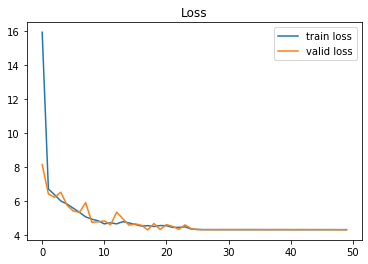

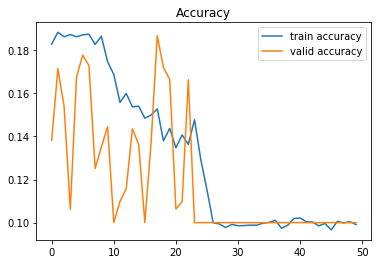

In [10]:
run(BATCH_SIZE)